In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from performance_measures import confusion_matrix,precision,rappel,specificite,taux_de_fp
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
%matplotlib inline

In [3]:
FEATURES_FILE_DIR = './Dataset/features.txt'
ENG_VOCAB_FEATURES_FILE_DIR = './Dataset/eng_vocab_features.txt'
HAM_CLEAN_DIR = './Dataset/ham_clean/'
SPAM_CLEAN_DIR = './Dataset/spam_clean/'
LTSM_SAVE_PATH = "./Models/LTSM/"
DEEP_NEURAL_NET_SAVE_PATH = "./Models/DEEP/"

# Making the tokeniser and defining utils

In [4]:
with open(ENG_VOCAB_FEATURES_FILE_DIR) as file :
    line = file.readline()
tokenizer = Tokenizer(num_words=len(line.split(" ")),oov_token="<OOV>")
tokenizer.fit_on_texts(line.split(" "))

In [5]:
def load_database():
    X=[]
    Y=[]
    #we start with the ham 
    for _ ,__ ,ham_files in os.walk(HAM_CLEAN_DIR):
        print("ham files found : ",len(ham_files))
    for file in ham_files :
        with open(HAM_CLEAN_DIR+file,encoding = "ISO-8859-1") as f:
           line = f.readlines()
        X.append(line[0].split(" "))
        Y.append(0)
    
    for _ ,__ ,spam_files in os.walk(SPAM_CLEAN_DIR):
        print("spam files found : ",len(spam_files))
    for file in spam_files :
        with open(SPAM_CLEAN_DIR+file,encoding = "ISO-8859-1") as f:
           line = f.readlines()
        X.append(line[0].split(" "))
        Y.append(1)
    
    X = tokenizer.texts_to_sequences(X)
    
    return X,Y

In [6]:
X,Y = load_database()

ham files found :  6951
spam files found :  2397


In [7]:
Xp = tf.keras.preprocessing.sequence.pad_sequences(X,3000)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Xp, Y, test_size=0.3)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index),64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1,activation="sigmoid")    
])
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          633088    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 666,177
Trainable params: 666,177
Non-trainable params: 0
_________________________________________________________________


In [11]:
# evaluating the bad model
model.evaluate(X_test,y_test)

88/88 [==============================] - 8s 68ms/step - loss: 0.6907 - accuracy: 0.7123


[0.6906879544258118, 0.7122994661331177]

In [12]:
# loading the trained model
model.load_weights(LTSM_SAVE_PATH+"ltsm")

In [13]:
# evaluating the trained model
model.evaluate(X_test,y_test)

88/88 [==============================] - 6s 66ms/step - loss: 0.0489 - accuracy: 0.9918


[0.04887646436691284, 0.9918003678321838]

# Small Test of LTSM

## Spam

In [15]:
s = 100

In [16]:
# read the file 
with open(SPAM_CLEAN_DIR+"spam"+str(s)+".txt",encoding = "ISO-8859-1") as f:
           line = f.readlines()
# transform it to tokens
S = tokenizer.texts_to_sequences([line[0].split(" ")])
# predict
model.predict(S)

array([[0.99794465]], dtype=float32)

## Ham

In [17]:
h = 7

In [18]:
# read the file 
with open(HAM_CLEAN_DIR+"ham"+str(h)+".txt",encoding = "ISO-8859-1") as f:
           line = f.readlines()
# transform it to tokens
H = tokenizer.texts_to_sequences([line[0].split(" ")])
# predict
model.predict(H)

array([[0.00877793]], dtype=float32)

# Performance of LSTM

In [19]:
y_true_ltsm = y_test
y_pred_scores_ltsm = np.squeeze(model.predict(X_test))
y_pred_ltsm = y_pred_scores_ltsm.copy()
y_pred_ltsm[y_pred_ltsm<0.5] = 0
y_pred_ltsm[y_pred_ltsm>=0.5] = 1
y_pred_ltsm = y_pred_ltsm.astype(int)

## Confusion matrix

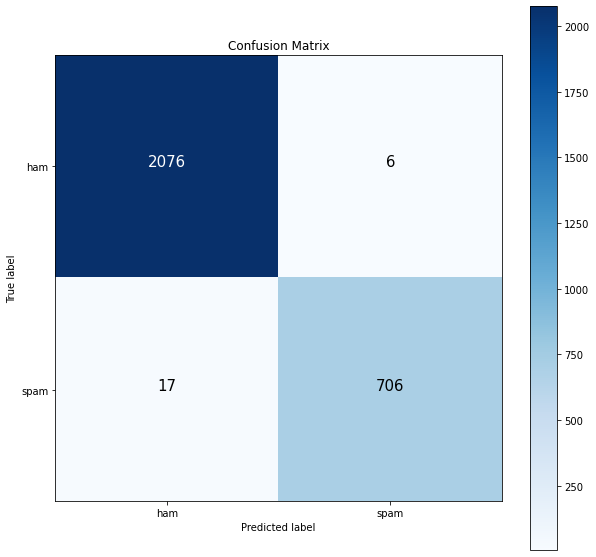

In [20]:
confusion_matrix(y_true_ltsm,y_pred_ltsm,["ham","spam"])

## Rappel

In [21]:
rappel(y_true_ltsm,y_pred_ltsm)

Rappel systeme : 0.986802507961942


## Precision

In [22]:
precision(y_true_ltsm,y_pred_ltsm)

Precision systeme : 0.9917253606188634


## False positive rate

In [23]:
taux_de_fp(y_true_ltsm,y_pred_ltsm)

Taux de FP de la classe 0 = 0.008122312470138558 , vp = 2076 , fp = 17
Taux de FP de la classe 1 = 0.008426966292134831 , vp = 706 , fp = 6


## Specificity

In [24]:
specificite(y_true_ltsm,y_pred_ltsm)

Specificite de la classe 0 = 0.9918776875298615 , vp = 2076 , fp = 17
Specificite de la classe 1 = 0.9915730337078652 , vp = 706 , fp = 6


## ROC 

In [149]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_true_ltsm, y_pred_scores_ltsm)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_ltsm.ravel(), y_pred_scores_ltsm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

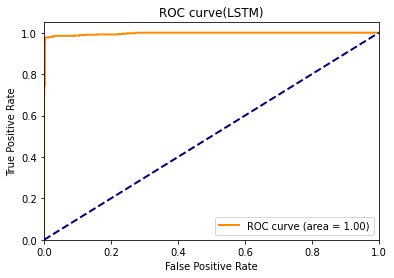

In [150]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve(LSTM)")
plt.legend(loc="lower right")
plt.show()

# Making the data ready for classic algorithms

In [27]:
def make_features(email_words_indexes):
    features = np.zeros(len(tokenizer.word_index)-1,dtype=int)
    for word_index in email_words_indexes :
        if word_index!=1: features[word_index-2]=1
    return features

In [28]:
X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(X, Y, test_size=0.3)

In [29]:
y_train_classic = np.array(y_train_classic)
y_test_classic = np.array(y_test_classic)

In [30]:
X_train_classic = np.array([make_features(x) for x in X_train_classic])
X_test_classic = np.array([make_features(x) for x in X_test_classic])

# Performance of Deep Neural Network

In [31]:
deep_neural_net_model = tf.keras.Sequential([
    tf.keras.layers.Input(len(tokenizer.word_index)-1),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1,activation="sigmoid")    
])
deep_neural_net_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
deep_neural_net_model.load_weights(DEEP_NEURAL_NET_SAVE_PATH+"deep_nnt")

In [38]:
deep_neural_net_model.evaluate(X_test_classic,y_test_classic)

88/88 [==============================] - 0s 3ms/step - loss: 0.0360 - accuracy: 0.9854


[0.03601866960525513, 0.9853832721710205]

In [39]:
y_true_dnn = y_test_classic
y_pred_scores_dnn = np.squeeze(deep_neural_net_model.predict(X_test_classic))
y_pred_dnn = y_pred_scores_dnn.copy()
y_pred_dnn[y_pred_dnn<0.5] = 0
y_pred_dnn[y_pred_dnn>=0.5] = 1
y_pred_dnn = y_pred_dnn.astype(int)

## Confusion matrix

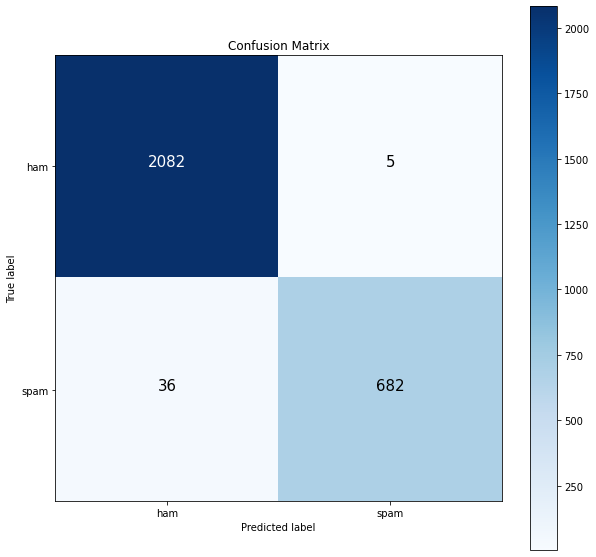

In [40]:
confusion_matrix(y_true_dnn,y_pred_dnn,["ham","spam"])

## Rappel

In [41]:
rappel(y_true_dnn,y_pred_dnn)

Rappel systeme : 0.9737324704064023


## Precision

In [42]:
precision(y_true_dnn,y_pred_dnn)

Precision systeme : 0.9878624062413663


## False positive rate

In [43]:
taux_de_fp(y_true_dnn,y_pred_dnn)

Taux de FP de la classe 0 = 0.0169971671388102 , vp = 2082 , fp = 36
Taux de FP de la classe 1 = 0.00727802037845706 , vp = 682 , fp = 5


## Specificity

In [44]:
specificite(y_true_dnn,y_pred_dnn)

Specificite de la classe 0 = 0.9830028328611898 , vp = 2082 , fp = 36
Specificite de la classe 1 = 0.992721979621543 , vp = 682 , fp = 5


## ROC 

In [45]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_true_dnn, y_pred_scores_dnn)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_dnn.ravel(), y_pred_scores_dnn.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

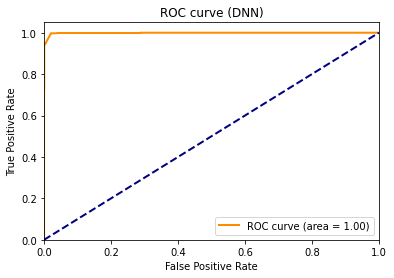

In [47]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (DNN)")
plt.legend(loc="lower right")
plt.show()

# Performance of SVM

In [64]:
C = 0.7
svc = svm.SVC(kernel='linear', C=C,probability=True)
classf = svc.fit(X_train_classic, np.squeeze(y_train_classic))
y_pred_svm = classf.predict(X_test_classic)
y_pred_svm_scores = classf.predict_log_proba(X_test_classic)

In [73]:
prcision_svm = np.mean(y_pred_svm==y_test_classic)*100
prcision_svm

97.18360071301248

## Confusion matrix

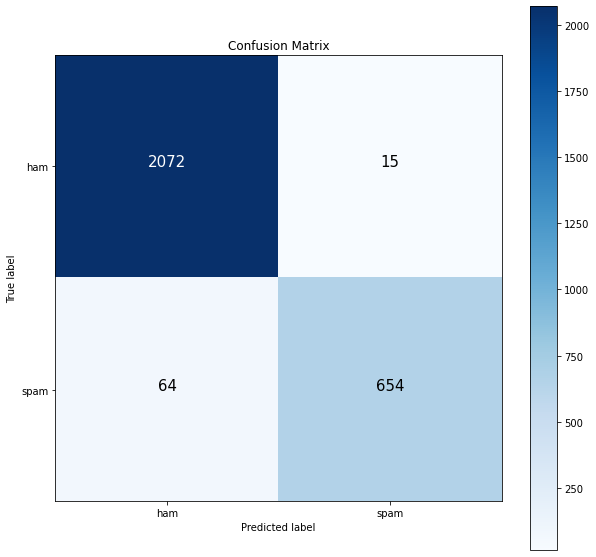

In [74]:
confusion_matrix(y_test_classic,y_pred_svm,["ham","spam"])

## Rappel

In [75]:
rappel(y_test_classic,y_pred_svm)

Rappel systeme : 0.9518380797428837


## Precision

In [76]:
precision(y_test_classic,y_pred_svm)

Precision systeme : 0.9738079642599218


## False positive rate

In [77]:
taux_de_fp(y_test_classic,y_pred_svm)

Taux de FP de la classe 0 = 0.0299625468164794 , vp = 2072 , fp = 64
Taux de FP de la classe 1 = 0.02242152466367713 , vp = 654 , fp = 15


## Specificity

In [78]:
specificite(y_test_classic,y_pred_svm)

Specificite de la classe 0 = 0.9700374531835206 , vp = 2072 , fp = 64
Specificite de la classe 1 = 0.9775784753363229 , vp = 654 , fp = 15


## ROC 

In [90]:
y_pred_svm_scores= y_pred_svm_scores[:,0]/(y_pred_svm_scores[:,0]+y_pred_svm_scores[:,1])

In [91]:
y_pred_svm_scores

array([7.97620159e-06, 6.20420780e-09, 3.11806775e-01, ...,
       3.08024489e-04, 9.66034836e-01, 1.55706844e-02])

In [147]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test_classic, y_pred_svm_scores)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_classic.ravel(), y_pred_svm_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

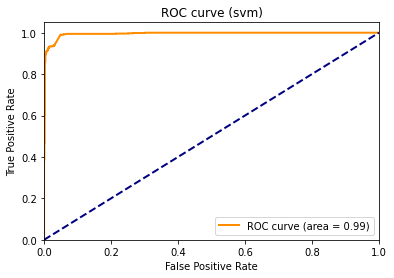

In [148]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (svm)")
plt.legend(loc="lower right")
plt.show()

# Performance of Decision tree

In [109]:
model_tree = DecisionTreeClassifier(max_depth=7)
# Entrainer le modèle
model_tree = model_tree.fit(X_train_classic, np.squeeze(y_train_classic))
# Prediction
y_pred_tree = model_tree.predict(X_test_classic)
y_pred_tree_scores = model_tree.predict_proba(X_test_classic)

In [110]:
prcision_of_tree = np.mean(y_pred_tree==y_test_classic)*100
prcision_of_tree

92.01426024955437

## Confusion matrix

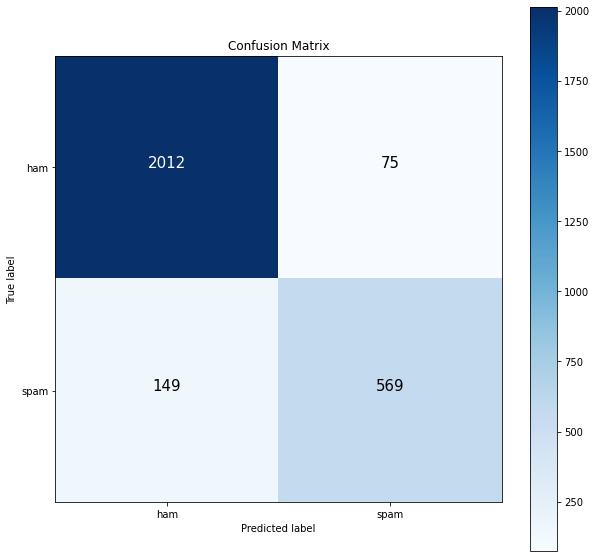

In [111]:
confusion_matrix(y_test_classic,y_pred_tree,["ham","spam"])

## Rappel

In [112]:
rappel(y_test_classic,y_pred_tree)

Rappel systeme : 0.8782711786587083


## Precision

In [113]:
precision(y_test_classic,y_pred_tree)

Precision systeme : 0.9072954061410492


## False positive rate

In [114]:
taux_de_fp(y_test_classic,y_pred_tree)

Taux de FP de la classe 0 = 0.06894956038870893 , vp = 2012 , fp = 149
Taux de FP de la classe 1 = 0.11645962732919254 , vp = 569 , fp = 75


## Specificity

In [115]:
specificite(y_test_classic,y_pred_tree)

Specificite de la classe 0 = 0.9310504396112911 , vp = 2012 , fp = 149
Specificite de la classe 1 = 0.8835403726708074 , vp = 569 , fp = 75


## ROC 

In [124]:
y_pred_tree_scores= y_pred_tree_scores[:,1]/(y_pred_tree_scores[:,0]+y_pred_tree_scores[:,1])

In [145]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test_classic, y_pred_tree_scores)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_classic.ravel(), y_pred_tree_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

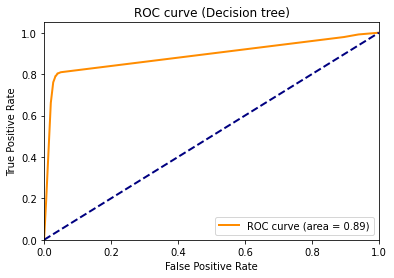

In [146]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Decision tree)")
plt.legend(loc="lower right")
plt.show()

# Performance of Random forest

In [128]:
randforest = RandomForestClassifier(max_depth=23, random_state=0)
randforest.fit(X_train_classic, np.squeeze(y_train_classic))
y_pred_rand_forrest = randforest.predict(X_test_classic)
y_pred_rand_forrest_scores = randforest.predict_proba(X_test_classic)

In [129]:
prcision_of_rand_forrest = np.mean(y_pred_rand_forrest==y_test_classic)*100
prcision_of_rand_forrest

94.01069518716577

## Confusion matrix

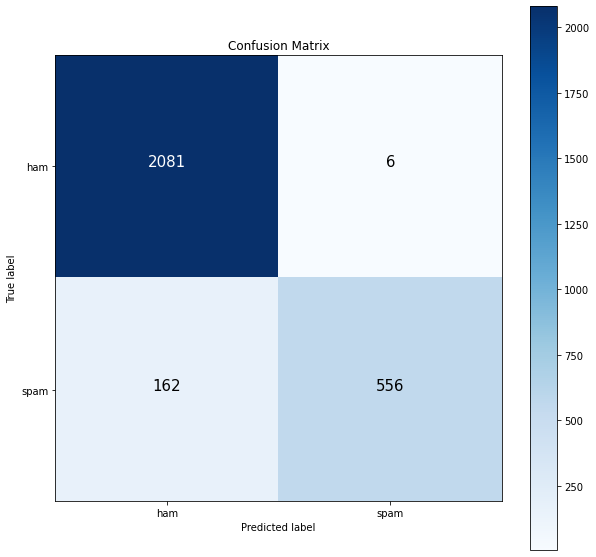

In [131]:
confusion_matrix(y_test_classic,y_pred_rand_forrest,["ham","spam"])

## Rappel

In [132]:
rappel(y_test_classic,y_pred_rand_forrest)

Rappel systeme : 0.8857491594737552


## Precision

In [133]:
precision(y_test_classic,y_pred_rand_forrest)

Precision systeme : 0.9585495721763081


## False positive rate

In [134]:
taux_de_fp(y_test_classic,y_pred_rand_forrest)

Taux de FP de la classe 0 = 0.0722246990637539 , vp = 2081 , fp = 162
Taux de FP de la classe 1 = 0.010676156583629894 , vp = 556 , fp = 6


## Specificity

In [135]:
specificite(y_test_classic,y_pred_rand_forrest)

Specificite de la classe 0 = 0.927775300936246 , vp = 2081 , fp = 162
Specificite de la classe 1 = 0.9893238434163701 , vp = 556 , fp = 6


## ROC 

In [136]:
y_pred_rand_forrest_scores


array([[0.94573168, 0.05426832],
       [0.8380948 , 0.1619052 ],
       [0.87857585, 0.12142415],
       ...,
       [0.86343732, 0.13656268],
       [0.54359491, 0.45640509],
       [0.8998205 , 0.1001795 ]])

In [140]:
y_pred_rand_forrest_scores= y_pred_rand_forrest_scores[:,1]/(y_pred_rand_forrest_scores[:,0]+y_pred_rand_forrest_scores[:,1])

In [141]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(y_test_classic, y_pred_rand_forrest_scores)
roc_auc[0] = auc(fpr[0], tpr[0])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_classic.ravel(), y_pred_rand_forrest_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

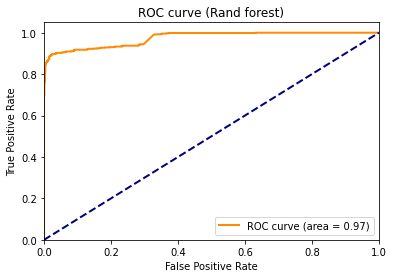

In [143]:
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Rand forest)")
plt.legend(loc="lower right")
plt.show()

# Performance of KNN